In [123]:
# Load required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import pymc3 as pm
import theano.tensor as tt
import scipy.stats as sp

from pymc3 import (
    NUTS,
    DensityDist,
    Dirichlet,
    MvNormal,
    Normal,
    Slice,
    sample,
)

In [124]:
# Configure graphics
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

In [125]:
# Load in data
trackman = pd.read_csv("trackman_data.csv")
blast = pd.read_csv("blast_data.csv")

In [126]:
# Create data frame of balls in play and drop rows with missing values
track_damage = trackman[trackman['PitchCall'] == 'InPlay'].copy()
track_damage.dropna(inplace=True)

In [127]:
# Create mappings and values for later use
all_batters = blast.BatterId.unique()
n_batters = len(all_batters)
batter_lookup = dict(zip(all_batters, range(n_batters)))
batter_idx = blast['batter_idx'] = blast.BatterId.replace(batter_lookup).values

In [128]:
track_batter_idx = track_damage['batter_idx'] = track_damage.BatterId.replace(batter_lookup).values
track_batters = track_damage.batter_idx.unique()
all_batters_idx = blast.batter_idx.unique()

In [129]:
# Function for calculating partially pooled means in a hierarchical model
def pooled_means(col, normal_sigma, cauchy_sigma, batter_idx):
    mean = col.mean()
    with pm.Model() as model:
        # Hyperpriors
        a = pm.Normal('a', mu=mean,sigma=normal_sigma)
        sigma_a = pm.HalfCauchy('sigma_a',cauchy_sigma)
    
        # Intercept of model
        a_batter = pm.Normal('a_batter',mu=a,sigma=sigma_a,shape=n_batters)
        # Expected value for each batter
        theta = a_batter[batter_idx]
        # Error of model
        sigma = pm.HalfCauchy('sigma',cauchy_sigma)
    
        # Fit to observed values
        y = pm.Normal('y',theta,sigma=sigma,observed=col.values)
        
        # Draws on 1000 samples and then tunes on 1000 more
        with model:
            trace = pm.sample(1000,tune=1000)
        
        return trace

In [130]:
# Use function to generate Bayesian models
attack_angle = pooled_means(blast["AttackAngle"],0.5,0.1,batter_idx)
bat_speed = pooled_means(blast["BatSpeed"],5.0,1.0,batter_idx)
connection = pooled_means(blast["Connection"],1.0,0.2,batter_idx)
early_connection = pooled_means(blast["EarlyConnection"],1.0,0.2,batter_idx)
planar_efficiency = pooled_means(blast["PlanarEfficiency"],1.0,0.2,batter_idx)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a_batter, sigma_a, a]
Sampling chain 1, 0 divergences: 100%|█████████████████████████████████████████████| 2000/2000 [04:24<00:00,  7.57it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a_batter, sigma_a, a]
Sampling chain 1, 0 divergences: 100%|█████████████████████████████████████████████| 2000/2000 [05:36<00:00,  5.95it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a_batter, sigma_a, a]
Sampling chain 1, 0 divergences: 100%|█████████████████████████████████████████████| 2000/2000 [04:35<00:00,  7.26it/s]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a_batter, sigma_a, a]
Sampling chain 1, 0 divergences:

In [131]:
# Extract mean values for each batter
attack_angle_mean = az.summary(attack_angle, var_names=['a_batter'], round_to=2)["mean"].values
bat_speed_mean = az.summary(bat_speed, var_names=['a_batter'], round_to=2)["mean"].values
connection_mean = az.summary(connection, var_names=['a_batter'], round_to=2)["mean"].values
early_connection_mean = az.summary(early_connection, var_names=['a_batter'], round_to=2)["mean"].values
planar_efficiency_mean = az.summary(planar_efficiency, var_names=['a_batter'], round_to=2)["mean"].values

C:\Users\Owner\Anaconda3n\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\Owner\Anaconda3n\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\Users\Owner\Anaconda3n\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
C:\User

In [132]:
# Combine all data into array
blast_est = np.vstack((attack_angle_mean,
                       bat_speed_mean,
                       connection_mean,
                       early_connection_mean,
                       planar_efficiency_mean)).T

In [133]:
# Put data in dataframe
blast_features = ["mean_attack_angle","mean_bat_speed",
                  "mean_connection","mean_early_connection","mean_planar_efficiency"]
blast_bat = pd.DataFrame(blast_est, columns=blast_features)

In [134]:
# Add index column into a new dataframe
all_batters_df = pd.DataFrame(all_batters_idx,columns=["batter_idx"])
blast_result = pd.concat([blast_bat, all_batters_df], axis=1)

In [135]:
# Calculate expected mean exit speed for each batter
exit_speed = pooled_means(track_damage["ExitSpeed"],10,2.5,track_batter_idx)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sigma, a_batter, sigma_a, a]
Sampling chain 1, 0 divergences: 100%|█████████████████████████████████████████████| 2000/2000 [00:23<00:00, 86.24it/s]


C:\Users\Owner\Anaconda3n\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001E061830780>,
      dtype=object)

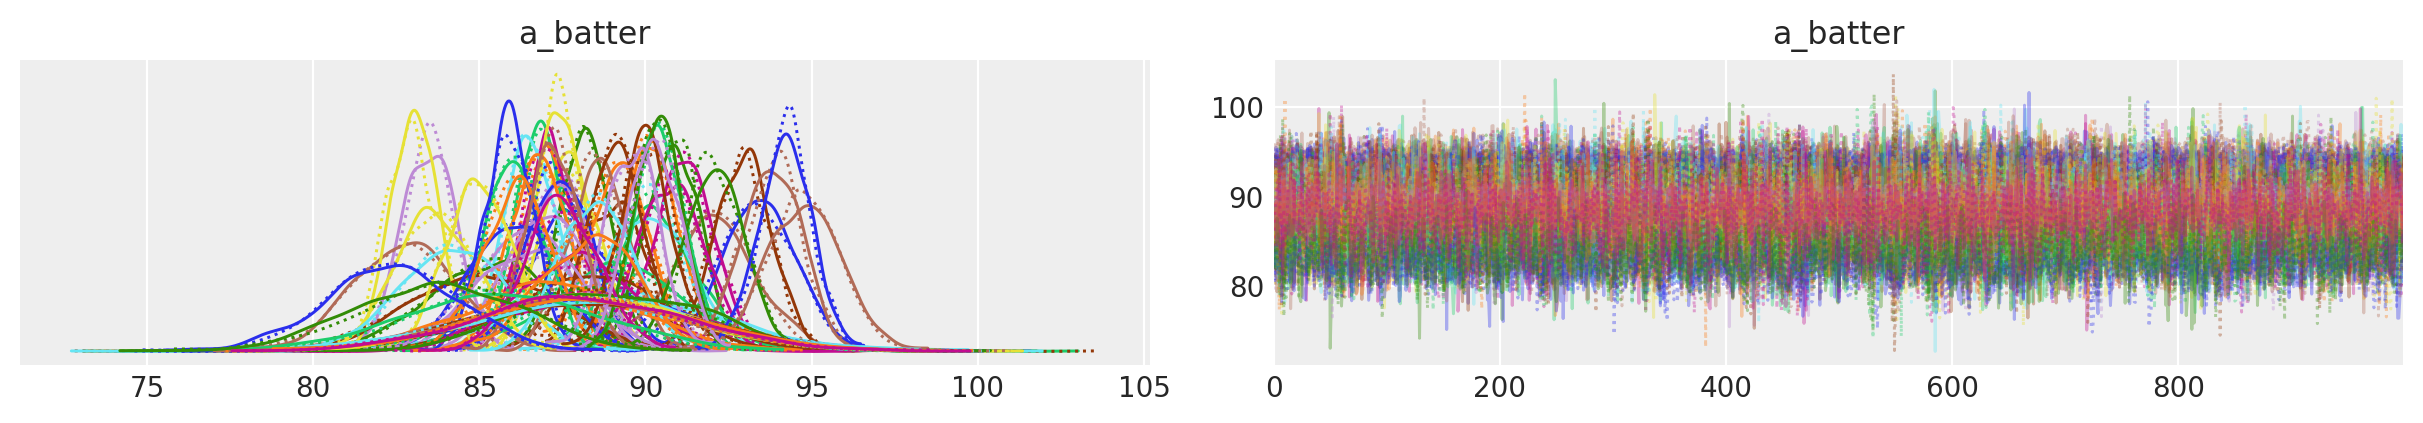

In [136]:
pm.traceplot(exit_speed, var_names=["a_batter"])

In [137]:
# Extract expected mean exit speed values for each batter
exit_speed_mean= az.summary(exit_speed, var_names=['a_batter'], round_to=2)["mean"].values
exit_df = pd.DataFrame(exit_speed_mean,columns=["mean_exit_speed"])

C:\Users\Owner\Anaconda3n\lib\site-packages\arviz\data\io_pymc3.py:91: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


In [138]:
# Combine expected blast values with expected exit velocities for each batter
blast_exit = pd.concat([blast_result, exit_df], axis=1)

C:\Users\Owner\Anaconda3n\lib\site-packages\seaborn\axisgrid.py:1306: UserWarning: This figure was using constrained_layout==True, but that is incompatible with subplots_adjust and or tight_layout: setting constrained_layout==False. 
  fig.tight_layout()


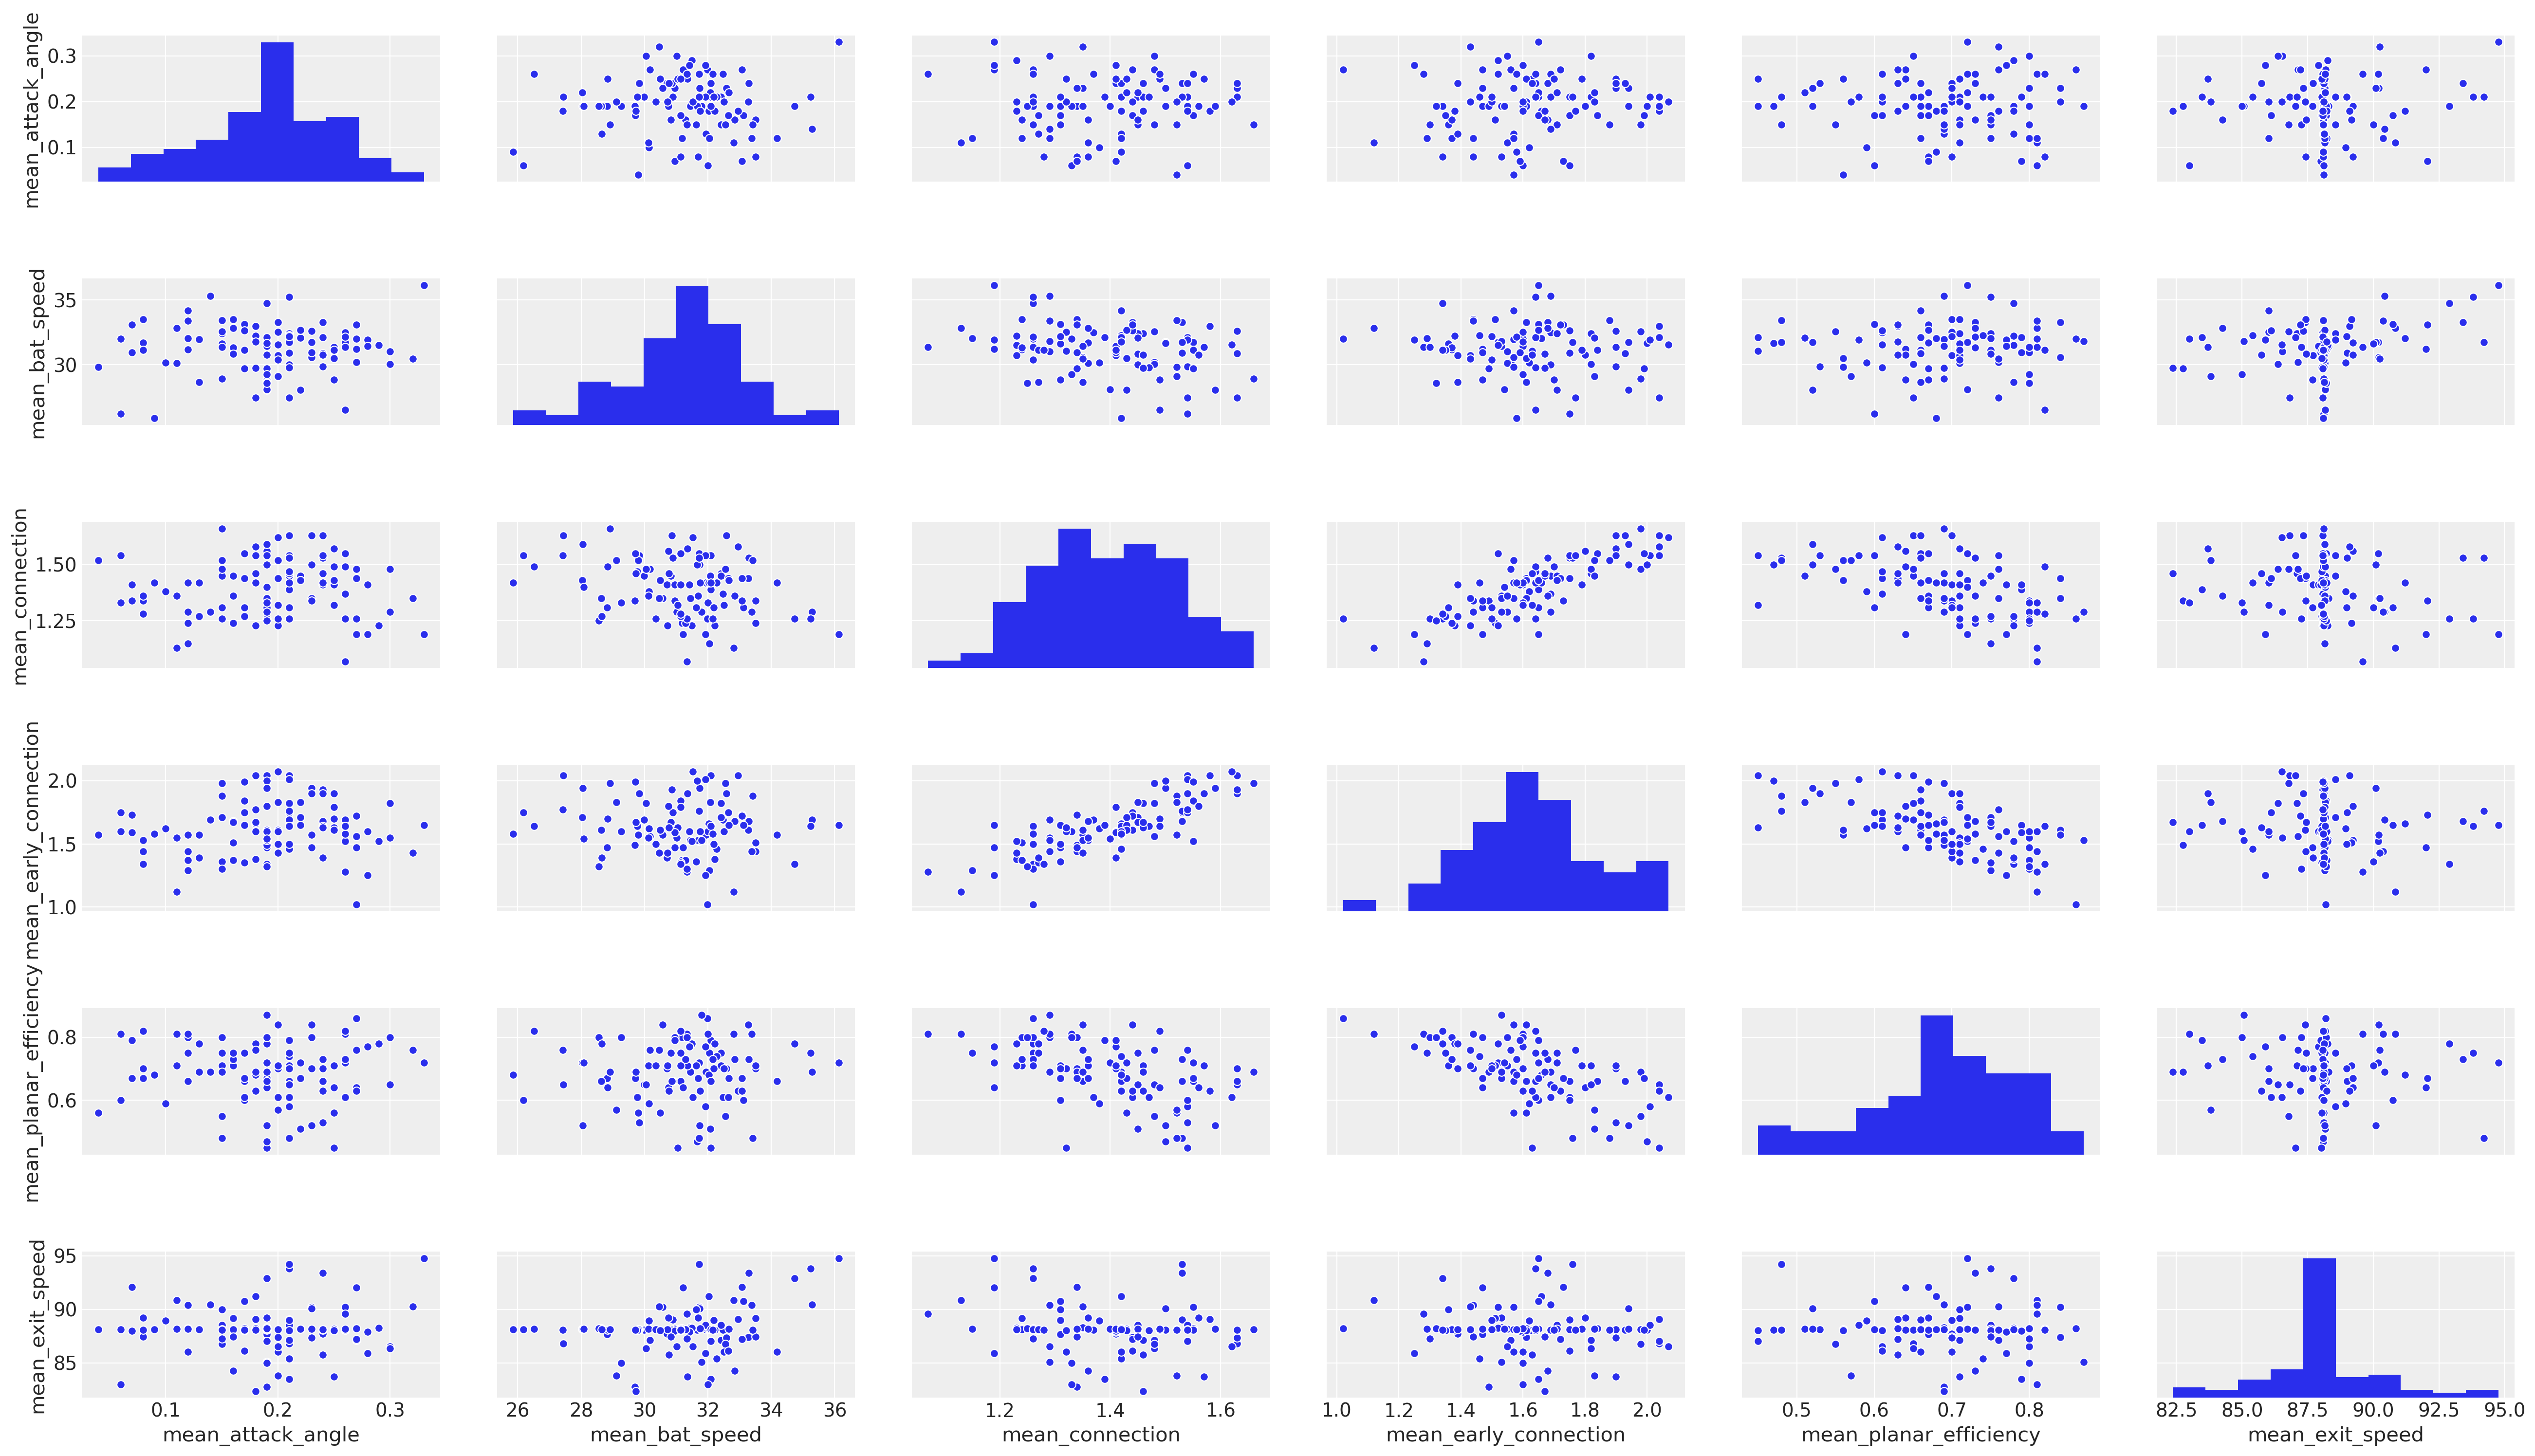

In [165]:
# Examine relationships between all skill estimates
# Some hitters have their entire exit speed estimate based on the pooled mean,
# which is represented by the straight line through the plots
sns.pairplot(blast_exit[blast_features+["mean_exit_speed"]],aspect=1.75)

In [154]:
# Create data frame of batters with Trackman measurements
bt = blast_exit[blast_exit["batter_idx"].isin(track_batters)]

Text(0.5, 0, 'Bat Speed Skill')

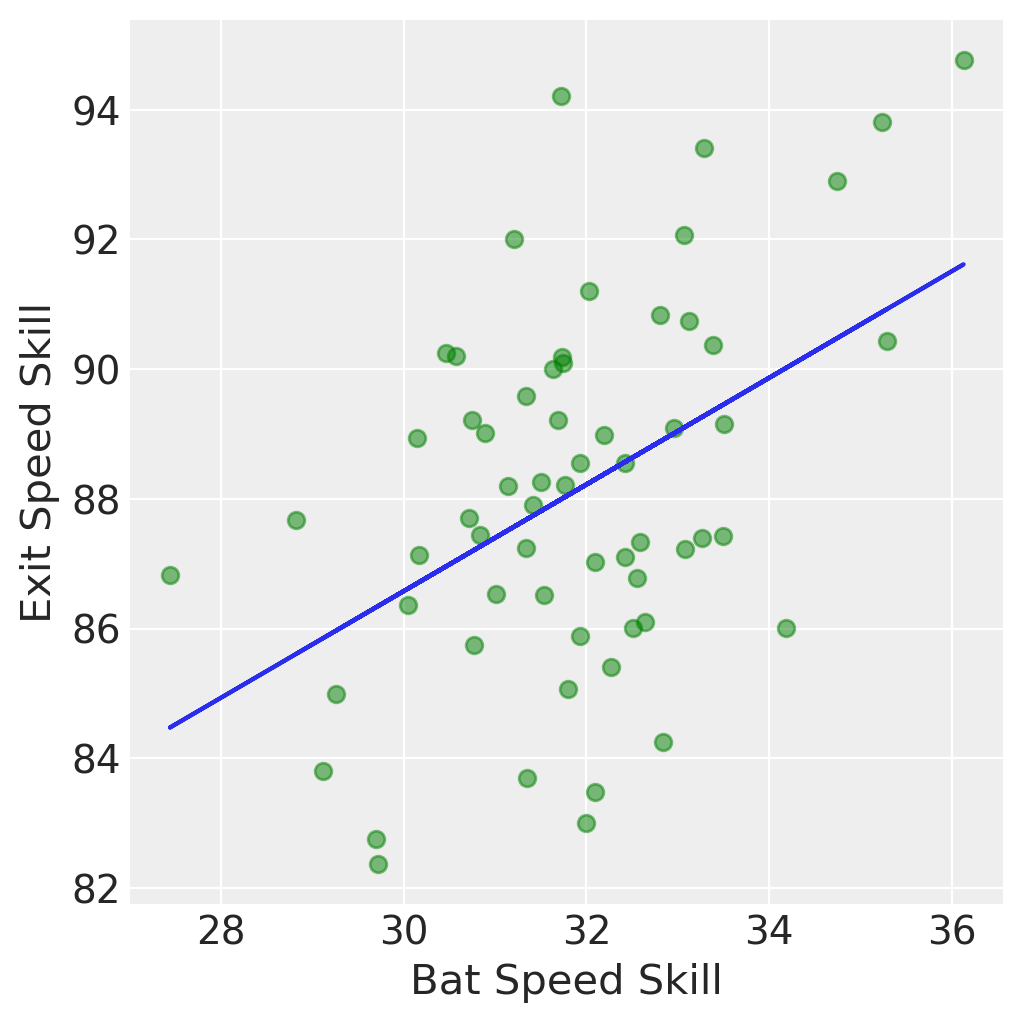

In [170]:
# Plotting exit speed vs bat speed for hitters with Trackman data
plt.figure(figsize=(5, 5))

x = bt["mean_bat_speed"]
y = bt["mean_exit_speed"]

plt.scatter(x, y, alpha=0.50, c="g")

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b)

plt.ylabel("Exit Speed Skill")
plt.xlabel("Bat Speed Skill")

Text(0.5, 0, 'Connection Skill')

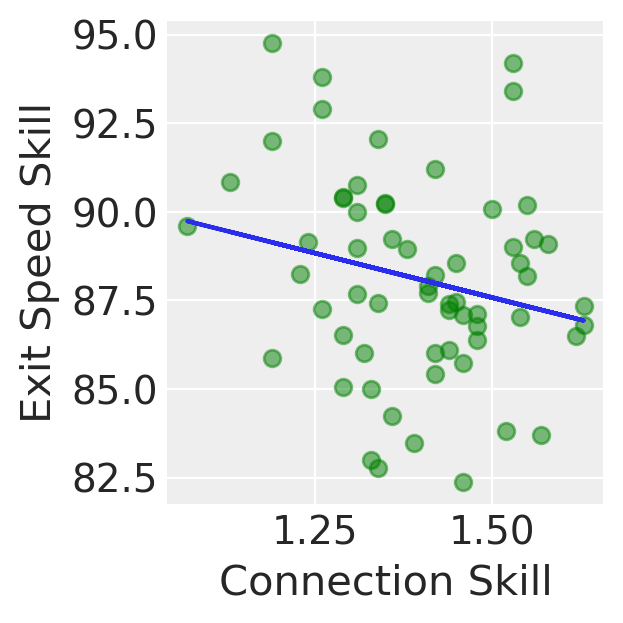

In [169]:
# Plotting exit speed vs connection for hitters with Trackman data
plt.figure(figsize=(3, 3))
x2 = bt["mean_connection"]
y2 = bt["mean_exit_speed"]
plt.scatter(x2, y2, alpha=0.50, c="g")
m2, b2 = np.polyfit(x2, y2, 1)
plt.plot(x2, m2*x2 + b2)
plt.ylabel("Exit Speed Skill")
plt.xlabel("Connection Skill")

In [145]:
# Create sample of 10000 blast observations
features = ["BatSpeed","Connection"]
blastsamp = blast.sample(10000)
blaster = blastsamp[features]
n_samples = blaster.shape[0]

The following code is adapted from a concept used [here](https://docs.pymc.io/notebooks/gaussian-mixture-model-advi.html).

In [84]:
from pymc3.math import logsumexp
from theano.tensor.nlinalg import det

# Log likelihood of normal distribution
def logp_normal(mu, tau, value):
    # log probability of individual samples
    k = tau.shape[0]
    delta = lambda mu: value - mu
    return (-1 / 2.0) * (
        k * tt.log(2 * np.pi)
        + tt.log(1.0 / det(tau))
        + (delta(mu).dot(tau) * delta(mu)).sum(axis=1)
    )


# Log likelihood of Gaussian mixture distribution
def logp_gmix(mus, pi, tau):
    def logp_(value):
        logps = [tt.log(pi[i]) + logp_normal(mu, tau, value) for i, mu in enumerate(mus)]

        return tt.sum(logsumexp(tt.stacklists(logps)[:, :n_samples], axis=0))

    return logp_

In [94]:
n_clusters = 4

with pm.Model() as model:
    # Prior standard deviation for bat speed and connection
    sd_dist = pm.Exponential.dist(2.0,shape=2)

    # Get unpacked Cholesky matrix
    packed_L = pm.LKJCholeskyCov("chol", n=2, eta=2.0, sd_dist=sd_dist)
    L = pm.expand_packed_triangular(2, packed_L)

    # Priors for bat speed and connection
    b1 = pm.Normal("bat_speed", mu=31.0, sigma=5.0)
    b2 = pm.Normal("connection", mu=1.4, sigma=0.5)
    
    # Create loop to find clusters of points
    mus = [
        pm.MvNormal("mu_%d" % i, mu=tt.stack([b1, b2]), chol=L, shape=(2,))
        for i in range(n_clusters)
    ] 
    
    # Dirichlet function 
    pi = Dirichlet("pi", pm.floatX(0.1*np.ones(n_clusters)), shape=(n_clusters,))
    xs = DensityDist("x", logp_gmix(mus, pi, np.eye(2)), observed=blaster)

In [97]:
# Run model trace
with model:
    trace = sample(1000,tune=1000,target_accept=0.95)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [pi, mu_3, mu_2, mu_1, mu_0, connection, bat_speed, chol]
Sampling chain 1, 2 divergences: 100%|█████████████████████████████████████████████| 2000/2000 [16:39<00:00,  2.00it/s]
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Text(0, 0.5, 'Connection')

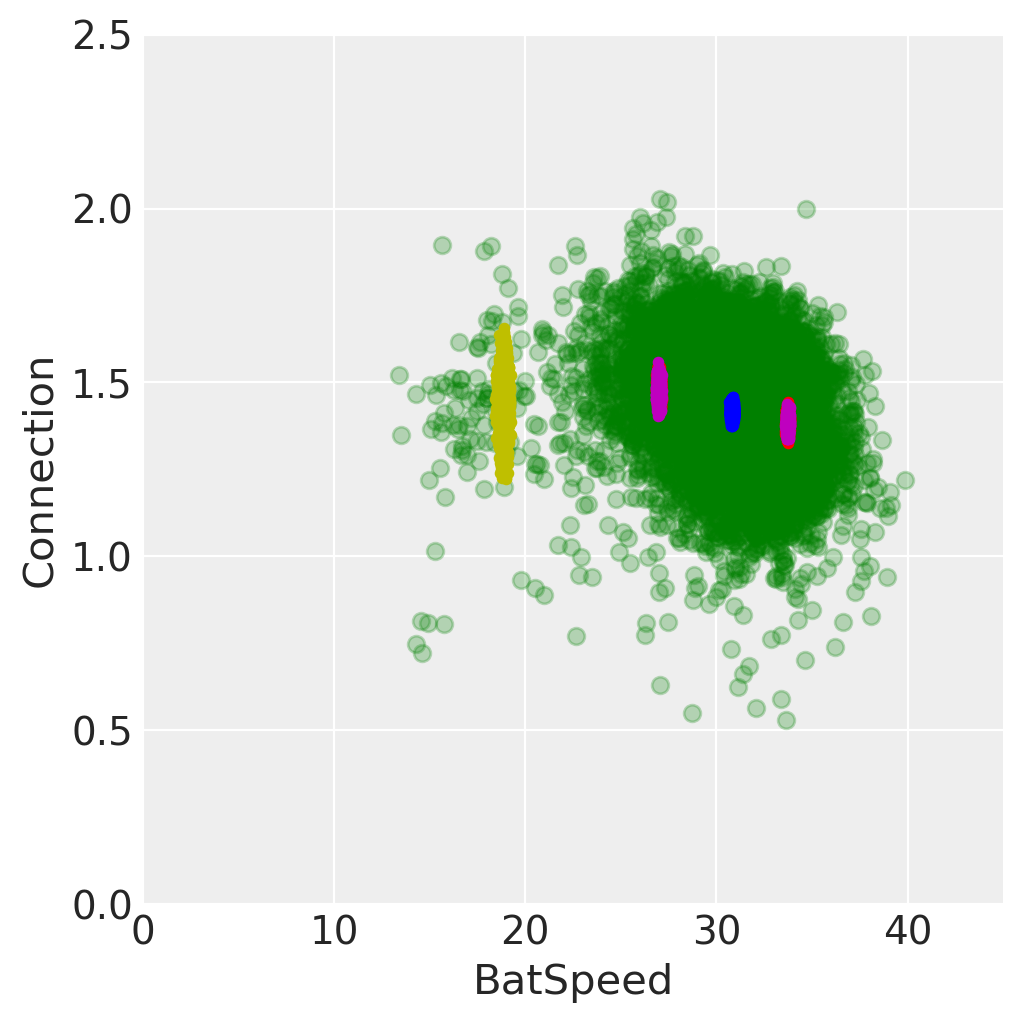

In [118]:
# Plot clusters
plt.figure(figsize=(5, 5))
plt.scatter(blaster[:, 0], blaster[:, 1], alpha=0.25, c="g")
mu_0, mu_1, mu_2, mu_3 = trace["mu_0"], trace["mu_1"], trace["mu_2"], trace["mu_3"]
plt.scatter(mu_0[:, 0], mu_0[:, 1], c="r", s=10)
plt.scatter(mu_1[:, 0], mu_1[:, 1], c="b", s=10)
plt.scatter(mu_2[:, 0], mu_2[:, 1], c="y", s=10)
plt.scatter(mu_3[:, 0], mu_3[:, 1], c="m", s=10)

plt.xlim(0,45)
plt.ylim(0,2.5)

plt.xlabel("BatSpeed")
plt.ylabel("Connection")

Text(0, 0.5, 'Posterior expected mixture weight')

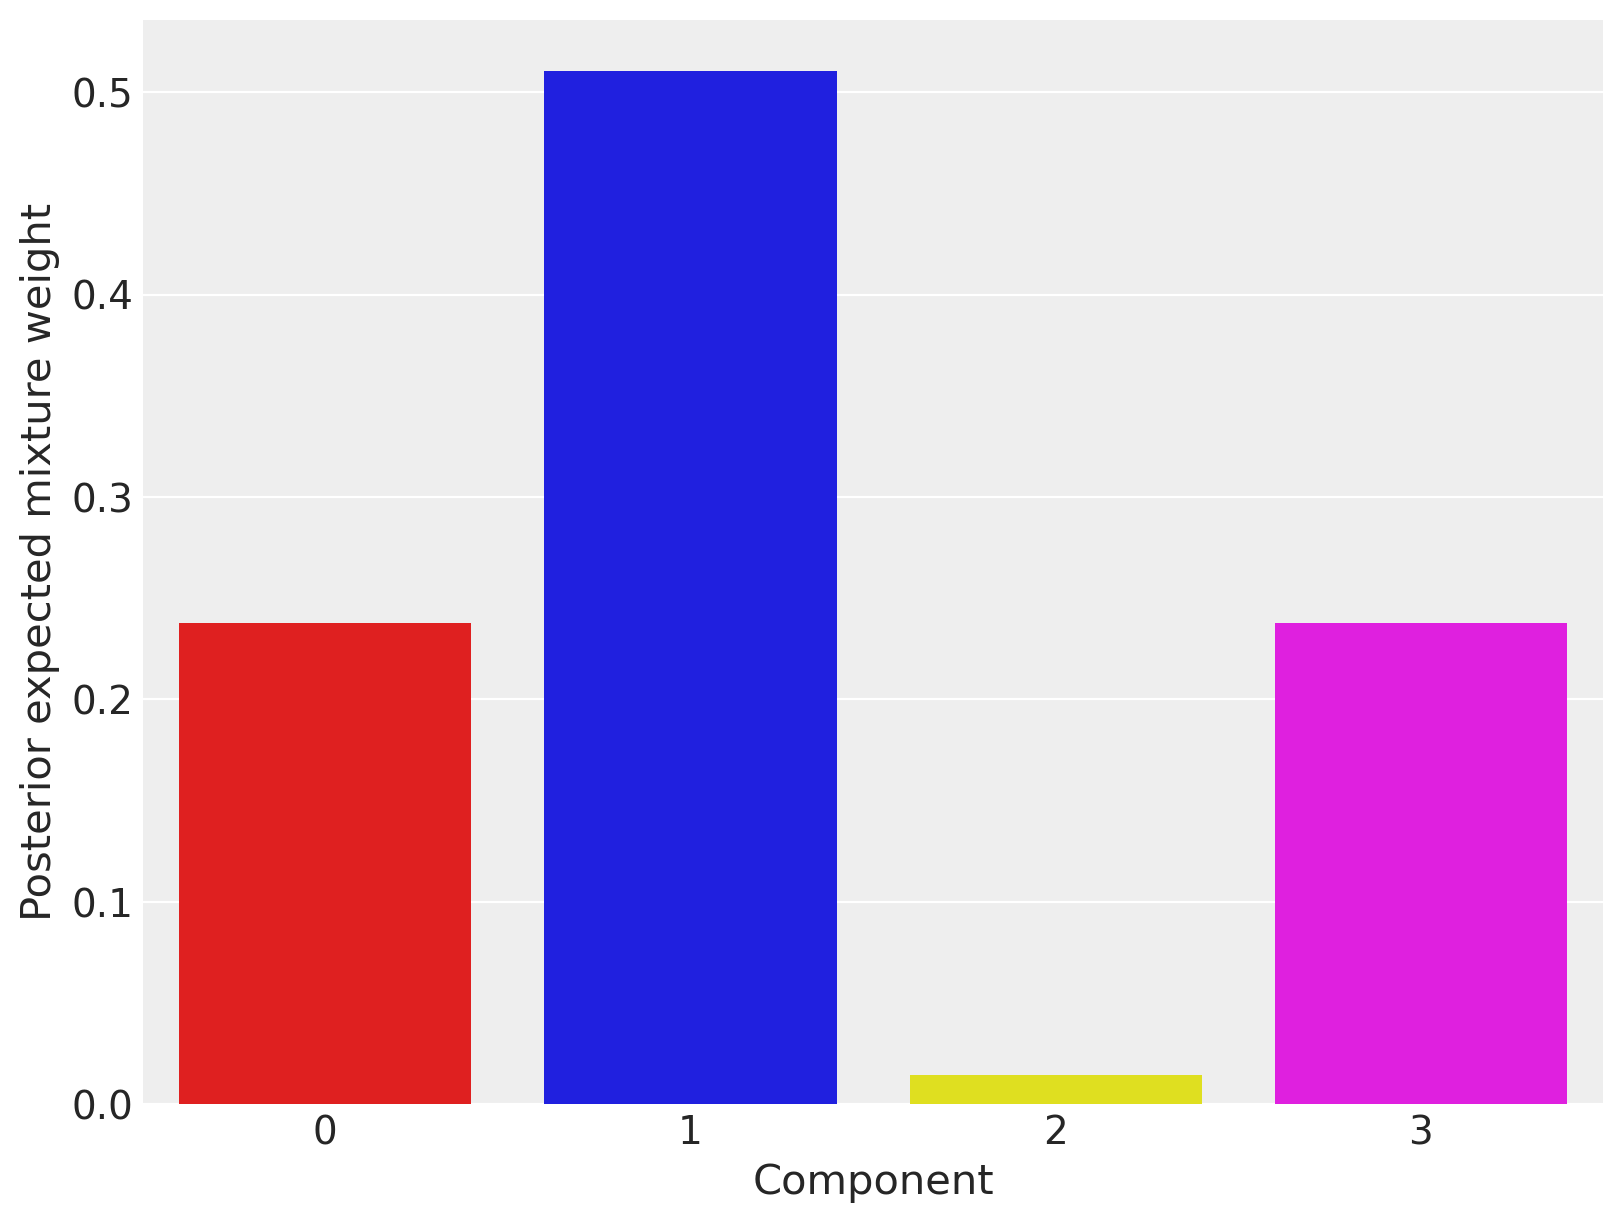

In [121]:
fig, ax = plt.subplots(figsize=(8, 6))

plot_w = np.arange(n_clusters) + 1

weights = trace["pi"][:]

sns.barplot([0, 1, 2, 3], np.mean(trace["pi"][:], 
            axis=0), palette=["red", "blue","yellow","magenta"])
plt.xlabel('Component')
plt.ylabel('Posterior expected mixture weight')